# Language Translation

## 1. Importing libraries and dataset

In [1]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

c:\Users\Sirikit Joshi\.conda\envs\cudaenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060 Laptop GPU'

In [3]:
import pandas as pd
data_raw = pd.read_csv("./dataset/translation.csv")
data_raw

,nepali,english
0,रन,Run
1,रन,Run
2,वाह,Wow
3,आगो,Fire
4,सहायता,Help
...,...,...
135836,एक कार्बन पदचाप हामी हाम्रो गतिविधिहरु को फलस्...,A carbon footprint is the amount of carbon dio...
135837,मृत्यु कुरा हामी अक्सर बारेमा कुरा गर्न निरुत्...,Death is something that we're often discourage...
135838,त्यहाँ कुनै पनि विषयमा सामान्यतया धेरै वेबसाइट...,Since there are usually multiple websites on a...
135839,आफ्नो पृष्ठभूमि थाहा नगर्ने कसैले तपाईंलाई एक ...,If someone who doesn't know your background sa...


In [4]:
data_raw.dropna(inplace=True)
data_raw.tail()

,nepali,english
135836,एक कार्बन पदचाप हामी हाम्रो गतिविधिहरु को फलस्...,A carbon footprint is the amount of carbon dio...
135837,मृत्यु कुरा हामी अक्सर बारेमा कुरा गर्न निरुत्...,Death is something that we're often discourage...
135838,त्यहाँ कुनै पनि विषयमा सामान्यतया धेरै वेबसाइट...,Since there are usually multiple websites on a...
135839,आफ्नो पृष्ठभूमि थाहा नगर्ने कसैले तपाईंलाई एक ...,If someone who doesn't know your background sa...
135840,यसलाई कारण सहयोगी प्रयास यस प्रकारको प्रकृति ए...,It may be impossible to get a completely error...


## 2. EDA

In [5]:
dataset = data_raw.values.tolist()
dataset_size = len(dataset)
dataset_size

135841

In [6]:
random.shuffle(dataset)
train_data_set_size = int(dataset_size *0.9)

train_dataset = dataset[:train_data_set_size]
test = dataset[train_data_set_size:]

train_size = int(train_data_set_size *0.9)
train = train_dataset[:train_size]
val = train_dataset[train_size:]

In [7]:
len(train),len(val),len(test)

(110030, 12226, 13585)

## 3.Preprocessing

In [8]:
SRC_LANGUAGE = 'np'
TRG_LANGUAGE = 'en'
# Place-holders
token_transform = {}
vocab_transform = {}

In [9]:
from attacut import tokenize, Tokenizer
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = Tokenizer(model="attacut-sc")
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')

In [10]:
#example of tokenization of the nepali part
print("Sentence: ", train[0][1])
print("Tokenization: ", token_transform[SRC_LANGUAGE].tokenize(train[0][1]))

Sentence:  The moment she was alone, she opened the letter
Tokenization:  ['The', ' ', 'moment', ' ', 'she', ' ', 'was', ' ', 'alone', ',', ' ', 'she', ' ', 'opened', ' ', 'the', ' ', 'letter']


In [11]:
#example of tokenization of the english part
print("Sentence: ", train[0][0])
print("Tokenization: ", token_transform[SRC_LANGUAGE].tokenize(train[0][0]))

Sentence:  त्यो एक्लै थियो क्षण, त्यो पत्र खोल्न
Tokenization:  ['त', '्', 'य', 'ो ', 'ए', 'क', '्', 'लै ', 'थ', 'ि', 'य', 'ो ', 'क', '्', 'ष', 'ण', ', ', 'त', '्य', 'ो ', 'प', 'त', '्', 'र ', 'ख', 'ो', 'ल', '्', 'न']


In [12]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        if language == SRC_LANGUAGE:
            yield token_transform[language].tokenize(data_sample[language_index[language]])
        elif language == TRG_LANGUAGE:
            yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

In [13]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [14]:
import pickle
with open('vocab.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(vocab_transform, file)

In [15]:
import pickle
with open('nepali_vocab.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(vocab_transform[TRG_LANGUAGE], file)

In [16]:
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[0, 0, 0, 0, 0]

In [17]:
vocab_transform[TRG_LANGUAGE](['उहाँले', 'एक', 'हो '])

[0, 0, 0]

In [18]:
#we can reverse its English....
mapping = vocab_transform[TRG_LANGUAGE].get_itos()
# #print 1816, for example
mapping[400]

'Stop'

In [19]:
#we can reverse its Thailand....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()
# #print 1816, for example
mapping[400]

' अ'

In [20]:
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

## 4. Preparing dataloader
We change <B>collate_fn</B> to return length of sentence required for <B>packed_padded_sequence</B>.

In [21]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import multiprocessing as mp
BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    global func
    def func(txt_input):
        for transform in transforms:
            if transform == token_transform[SRC_LANGUAGE]:
                txt_input = transform.tokenize(txt_input)
            else:
                txt_input = transform(txt_input)
        return txt_input

    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor

# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    import pickle
        
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [22]:
text_transform


{'np': <function __main__.func(txt_input)>,
 'en': <function __main__.func(txt_input)>}

### Create train, val, and test dataloaders

In [23]:
batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

In [24]:
for np, _, en in train_loader:
    break

In [25]:
print("nepali shape: ", np.shape)  # (seq len, batch_size)
print("English shape: ", en.shape)   # (seq len, batch_size)

nepali shape:  torch.Size([36, 32])
English shape:  torch.Size([12, 32])


In [26]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [27]:
print(train_loader_length)
print(val_loader_length)
print(test_loader_length)

3439
383
425


In [28]:
train_loader_length = 3439
val_loader_length = 383
test_loader_length = 425

In [29]:
train_loader_length, val_loader_length, test_loader_length  

(3439, 383, 425)

## 5. Design the model

In [30]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src: [src len, batch size]
        #src len: [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                            src_len.to('cpu'), enforce_sorted=False)
        
        #packed_outputs contain all hidden states including padding guy
        #hidden contains the last hidden states of the non-padded guys
        packed_outputs, hidden = self.rnn(packed_embedded)
        #hidden: [n layers * num directions, batch size, hid dim]
        
        #convert packed_outputs to the guy that does not contain hidden states for padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs: [src len, batch size, hid dim * num directions]
        
        #take the last hidden states from backward and forward
        #hidden: (f, b, f, b)
        forward  = hidden[-2, :, :]  #[batch size, hid dim]
        backward = hidden[-1, :, :]  #[batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((forward, backward), dim = 1))) 
        #hidden: [batch size, hid dim]
        
        return outputs, hidden

### Attention

In [31]:
class Attention(nn.Module):
    def __init__(self, hid_dim, variants):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]

        if self.variants == 'additive': #work
            #repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            #hidden = [batch size, src len, hid dim]
            
            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
            #energy = [batch size, src len, hid dim]
            
            attention = self.v(energy).squeeze(2)
            #attention = [batch size, src len]
            
        elif self.variants == 'general': #work
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
            #hidden = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)
            #attention = [batch size, src len]

        elif self.variants == 'multiplicative':
            wh = self.W(hidden).unsqueeze(1).repeat(1, 1, 2)
            #wh = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(wh, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)

        #use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        #attention = [batch size, src len]
        return F.softmax(attention, dim = 1)

In [32]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


### Decoder

In [33]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #Ct
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
        
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [1, batch size, hid dim]
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

In [34]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        #src: [src len, batch size]
        
        mask = (src == self.src_pad_idx).permute(1, 0)
        #mask: [batch size, src len]
        #we need to permute to make the mask same shape as attention...
        return mask

        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src: [src len, batch size]
        #src len: [batch size]
        #trg: [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim #define in decoder
        
        #because decoder decodes each step....let's create a list that gonna append the result to this guy
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #because decoder decodes each step....let's memorize the attention done in each step....
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #let's start!!!
        #1. encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs: [src len, batch size, hid dim * num directions]
        #hidden: [batch size, hid dim]
        
        #set the first input to the decoder
        input_ = trg[0,:]  #basically <sos>
        
        #create the mask for use in this step
        mask = self.create_mask(src)
        
        #2. for each of trg word
        for t in range(1, trg_len):

            #3. decode (hidden is always carry forward)
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output:   [batch size, output_dim]
            #hidden:   [batch size, hid_dim]
            #attention::[batch size, src len]  ==> how each of src token is important to input_ 
            
            #4. append the results to outputs and attentions
            outputs[t] = output
            attentions[t] = attention
            
            #5. get the result, using argmax
            top1 = output.argmax(1)  #find the maximum index of dimension 1, which is output_dim
            
            #6. based on the teacher forcing ratio, 
            teacher_force_or_not = random.random() < teacher_forcing_ratio
                    #if teacher forcing, next input is the next trg
                    #if no teacher forcing, the next input is the argmax guy...
            input_ = trg[t] if teacher_force_or_not else top1  #autoregressive
            
        return outputs, attentions #outputs for predicting the word, attentions to see which word is important

In [35]:
def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [36]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='additive')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model_additive = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model_additive.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(5751, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(9008, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=9008, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [37]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model_additive)

1472256
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
2306048
1966080
786432
  1536
  1536
16142336
  9008
______
26363440


## 6. Training

In [38]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model_additive.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

In [39]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [40]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [41]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [44]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'./model/{model_additive.__class__.__name__}_fullSCB.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model_additive, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model_additive, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_additive.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 19m 45s
	Train Loss: 1.123 | Train PPL:   3.075
	 Val. Loss: 1.853 |  Val. PPL:   6.376
Epoch: 02 | Time: 26m 5s
	Train Loss: 0.966 | Train PPL:   2.626
	 Val. Loss: 1.838 |  Val. PPL:   6.285
Epoch: 03 | Time: 295m 1s
	Train Loss: 0.880 | Train PPL:   2.410
	 Val. Loss: 1.859 |  Val. PPL:   6.417
Epoch: 04 | Time: 12m 44s
	Train Loss: 0.847 | Train PPL:   2.333
	 Val. Loss: 1.898 |  Val. PPL:   6.674
Epoch: 05 | Time: 11m 59s
	Train Loss: 0.820 | Train PPL:   2.271
	 Val. Loss: 1.936 |  Val. PPL:   6.934


Text(0, 0.5, 'loss')

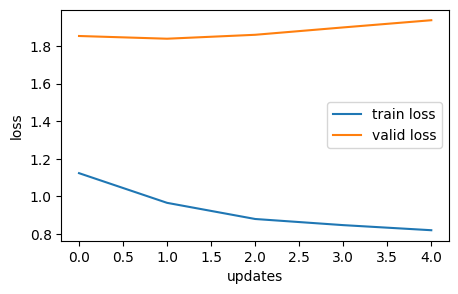

In [45]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [46]:
model_additive.load_state_dict(torch.load(save_path))
test_loss = evaluate(model_additive, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.824 | Test PPL:   6.194 |


## 7. Testing on random dataset

In [47]:
dataset[0][0], dataset[0][1]

('त्यो एक्लै थियो क्षण, त्यो पत्र खोल्न',
 'The moment she was alone, she opened the letter')

In [48]:
src_text = text_transform[SRC_LANGUAGE](dataset[0][0]).to(device)
trg_text = text_transform[TRG_LANGUAGE](dataset[0][1]).to(device)
src_text, trg_text

(tensor([  2,  11,   5,  18,  21,  28,  10,   5, 694,  37,  16,  18,  21,  10,
           5,  68,  88,  61,  11,  75,  21,  17,  11,   5,  49,  48,  20,  15,
           5,   8,   3], device='cuda:0'),
 tensor([  2,  35, 584, 119,  23, 178,  20, 119, 857,   7, 330,   3],
        device='cuda:0'))

In [49]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1
trg_text = trg_text.reshape(-1, 1)
src_text.shape, trg_text.shape

(torch.Size([31, 1]), torch.Size([12, 1]))

In [50]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [51]:
model_additive.load_state_dict(torch.load(save_path))

model_additive.eval()
with torch.no_grad():
    output, attentions = model_additive(src_text, text_length, trg_text, 0) #turn off teacher forcing

In [52]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([12, 1, 9008])

In [53]:
output = output.squeeze(1)
output.shape

torch.Size([12, 9008])

In [54]:
output_max = output.argmax(1) #returns max indices
output_max

tensor([  0,  33, 584, 119,  23, 178,  20, 119, 857,   7, 330,   3],
       device='cuda:0')

In [55]:
for token in output_max:
    print(mapping[token.item()])

<unk>
े 
ि उ
् 
ु
न प
ो
् 
त त
म
िनीहरू
<eos>


## 8. Attention

In [56]:

attentions.shape

torch.Size([12, 1, 31])

In [57]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE].tokenize(dataset[0][1]) + ['<eos>']
src_tokens

['<sos>',
 'The',
 ' ',
 'moment',
 ' ',
 'she',
 ' ',
 'was',
 ' ',
 'alone',
 ',',
 ' ',
 'she',
 ' ',
 'opened',
 ' ',
 'the',
 ' ',
 'letter',
 '<eos>']

In [58]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 '<unk>',
 'े ',
 'ि उ',
 '् ',
 'ु',
 'न प',
 'ो',
 '् ',
 'त त',
 'म',
 'िनीहरू',
 '<eos>']

In [59]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=10)
    
    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence 
     
    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

C:\Users\Sirikit Joshi\AppData\Local\Temp\ipykernel_11876\59549304.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
C:\Users\Sirikit Joshi\AppData\Local\Temp\ipykernel_11876\59549304.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)
C:\Users\Sirikit Joshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Sirikit Joshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Sirikit Joshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 2367 (\N{DEVANAGARI VOWEL SIGN I}) missing from current font.
  fig

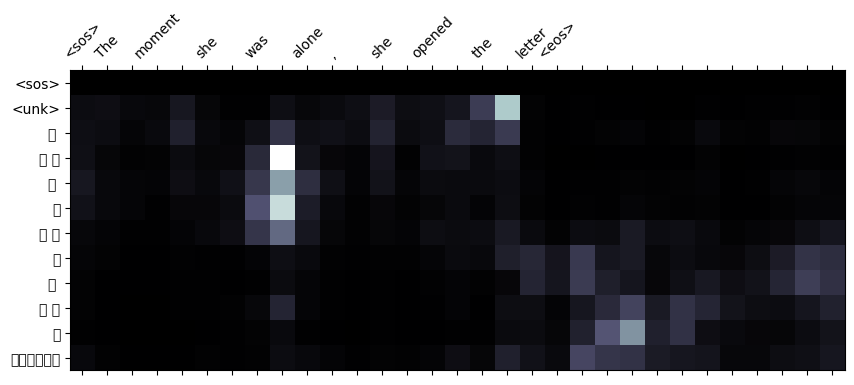

In [60]:
display_attention(src_tokens, trg_tokens, attentions)